In [4]:
# pip install xlsxwriter
# pip install PyExecJS
# pip install pdfkit
# pip install selenium tabula-py openpyxl
# pip uninstall easyocr
# conda install easyocr

# **MANAGE LIBRARIES**

In [1]:
# Import Libraries
import pandas as pd
import requests
from requests.adapters import Retry
from requests.exceptions import RequestException
from bs4 import BeautifulSoup
import xlsxwriter 
import urllib3  # to turn off warning
import csv
import urllib.request
import time
import execjs
import os
from io import StringIO
from collections import defaultdict
import matplotlib.pyplot as plt


from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pdfkit
from pdf2image import convert_from_path
import fitz  # PyMuPDF
from pdf2image import convert_from_path
from PIL import Image
import pytesseract

from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.webdriver import WebDriver
from selenium.webdriver.chrome.options import Options
from tabula.io import convert_into

## ****Construct URL****

In [ ]:
# Define the URL
# url = "https://hdsc.nws.noaa.gov/pfds/pfds_printpage.html?lat=38.0000&lon=-95.0000&data=depth&units=english&series=pds#table" # print table
# url = "https://hdsc.nws.noaa.gov/pfds/pfds_map_cont.html?lat=40&lon=-100"  #Xingong table
url_all = "https://hdsc.nws.noaa.gov/cgi-bin/new/fe_text.csv?lat=40.0000&lon=-96.0000&data=depth&units=english&series=pds&selAddr=-&selElevNum=-&selElevSym=ft&selStaName=-"      # ALL
url_mean = "https://hdsc.nws.noaa.gov/cgi-bin/new/fe_text_mean.csv?lat=40.0000&lon=-96.0000&data=depth&units=english&series=pds&selAddr=-&selElevNum=-&selElevSym=ft&selStaName=-" # Mean
url_upper = "https://hdsc.nws.noaa.gov/cgi-bin/new/fe_text_uppr.csv?lat=40.0000&lon=-96.0000&data=depth&units=english&series=pds&selAddr=-&selElevNum=-&selElevSym=ft&selStaName=-" #_uppr
url_lower = "https://hdsc.nws.noaa.gov/cgi-bin/new/fe_text_lwr.csv?lat=40.0000&lon=-96.0000&data=depth&units=english&series=pds&selAddr=-&selElevNum=-&selElevSym=ft&selStaName=-" #_lwr

## ****New Method (Extract Atlas-14)****

In [2]:
# Define loaction coordinate
latitude = 38.4103   # 40.0000  
longitude = -98.9941 # -96.0000  
latitude = str(latitude)
longitude = str(longitude)

# data_type = "" # All
data_type = "_mean" # mean
# data_type = "_uppr" # upper
# data_type = "_lwr" # lower


# URL with the provided coordinates
url = f"https://hdsc.nws.noaa.gov/cgi-bin/new/fe_text{data_type}.csv?lat={latitude}&lon={longitude}&data=depth&units=english&series=pds&selAddr=-&selElevNum=-&selElevSym=ft&selStaName=-"
# url = "https://hdsc.nws.noaa.gov/cgi-bin/new/fe_text_mean.csv?lat=40.0000&lon=-96.0000&data=depth&units=english&series=pds&selAddr=-&selElevNum=-&selElevSym=ft&selStaName=-"
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

try:
    # Send an HTTP GET request to the URL
    response = requests.get(url, verify=False)

    # Parse the CSV data from the response content
    csv_data = StringIO(response.text)

    # Read the CSV data
    csv_reader = csv.reader(csv_data)
    
    # Define the path for the new CSV file
    output_file_path = "atlas14_table_data.csv"

    # Open the new CSV file for writing
    with open(output_file_path, "w", newline="") as output_file:
        csv_writer = csv.writer(output_file)

        # Write each row from the fetched CSV data to the new file
        for row in csv_reader:
            csv_writer.writerow(row)

    print("CSV data has been successfully extracted and saved to 'noaa_table_data.csv'")

except Exception as e:
    print(f"An error occurred: {e}")

CSV data has been successfully extracted and saved to 'noaa_table_data.csv'


## ****Return Period vs Frequency Count****

In [ ]:
# Function to fetch and parse NOAA data for a given latitude and longitude
def fetch_noaa_data(latitude, longitude):
    url = f"https://hdsc.nws.noaa.gov/cgi-bin/new/fe_text_mean.csv?lat={latitude}&lon={longitude}&data=depth&units=english&series=pds&selAddr=-&selElevNum=-&selElevSym=ft&selStaName=-"
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
    response = requests.get(url, verify=False)
    
    if response.status_code == 200:
        # Extract data after "by duration for ARI (years):" line
        data = response.text.split("by duration for ARI (years):")[1]
        # Convert the data to a pandas DataFrame
        df = pd.read_csv(StringIO(data), header=None, skipinitialspace=True)
        return df
    else:
        return None

# Function to determine the column for IM30mR value
def find_im30mr_column(df, im30mr):
    im30mr_row = df[df[0] == '30-min:'].iloc[0, 1:] # 30-min:, 60-min:, 2-hr:, 3-hr:, 6-hr:, 12-hr:, 24-hr:, 2-day:, 3-day:
    
    # Initialize im30mr_column to None
    im30mr_column = None
    
    for col_label, value in im30mr_row.iteritems():
        if im30mr <= value:
            im30mr_column = col_label
            break
    
    # If im30mr_column is None, it means im30mr is greater than all values
    # Assign the last column label (1000) in this case
    if im30mr_column is None:
        im30mr_column = "1000"
    
    return im30mr_column

# Read the Gages CSV file
gages_df = pd.read_csv("Gages.csv")

# Create a DataFrame to store the results
results_df = pd.DataFrame(columns=["Latitude", "Longitude", "IM30mR", "Column"])  
# H30mR	H1hR	H2hR	H3hR	H6hR	H12hR	H24hR	H2DR	H3DR         # Hershfield
# IM30mR	IM1hR	IM2hR	IM3hR	IM6hR	IM12hR	IM24hR	IM2DR	IM3DR    # WMO


# Process each coordinate pair
for index, row in gages_df.iterrows():
    latitude = row["Latitude"]
    longitude = row["Longitude"]
    im30mr = row["IM30mR"]
    
    noaa_data = fetch_noaa_data(latitude, longitude)
    
    if noaa_data is not None:
        column = find_im30mr_column(noaa_data, im30mr)
        new_row = {"Latitude": latitude, "Longitude": longitude, "IM30mR": im30mr, "Column": column}
        results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

# Perform frequency count
frequency_count = results_df["Column"].value_counts().reset_index()
frequency_count.columns = ["Column", "Frequency"]

# Save results to a new CSV file
frequency_count.to_csv("ImergPMP_atlas14_comparison_30m.csv", index=False)
print("Frequency data has been successfully calculated and saved to csv")

## ****Find Coordinate Pairs Outside the 20-25 Year Return Period****

In [4]:
# Function to fetch and parse NOAA data for a given latitude and longitude
def fetch_noaa_data(latitude, longitude):
    url = f"https://hdsc.nws.noaa.gov/cgi-bin/new/fe_text_mean.csv?lat={latitude}&lon={longitude}&data=depth&units=english&series=pds&selAddr=-&selElevNum=-&selElevSym=ft&selStaName=-"
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
    response = requests.get(url, verify=False)
    
    if response.status_code == 200:
        # Extract data after "by duration for ARI (years):" line
        data = response.text.split("by duration for ARI (years):")[1]
        # Convert the data to a pandas DataFrame
        df = pd.read_csv(StringIO(data), header=None, skipinitialspace=True)
        return df
    else:
        return None

# Function to determine the column for IM30mR value
def find_im30mr_column(df, im30mr):
    im30mr_row = df[df[0] == '3-day:'].iloc[0, 1:] # 30-min:, 60-min:, 2-hr:, 3-hr:, 6-hr:, 12-hr:, 24-hr:, 2-day:, 3-day:
    
    # Initialize im30mr_column to None
    im30mr_column = None
    
    for col_label, value in im30mr_row.iteritems():
        if im30mr <= value:
            im30mr_column = col_label
            break
    
    # If im30mr_column is None, it means im30mr is greater than all values
    # Assign the last column label (1000) in this case
    if im30mr_column is None:
        im30mr_column = "1000"
    
    return im30mr_column

# Read the Gages CSV file
gages_df = pd.read_csv("Gages.csv")

# Create a DataFrame to store the latitude and longitude pairs that do not fall within the row value of 6
filtered_coordinates_df = pd.DataFrame(columns=["Latitude", "Longitude"])  
# H30mR	H1hR	H2hR	H3hR	H6hR	H12hR	H24hR	H2DR	H3DR         # Hershfield
# IM30mR	IM1hR	IM2hR	IM3hR	IM6hR	IM12hR	IM24hR	IM2DR	IM3DR    # WMO

# Process each coordinate pair
for index, row in gages_df.iterrows():
    latitude = row["Latitude"]
    longitude = row["Longitude"]
    im30mr = row["IM3DR"]
    
    noaa_data = fetch_noaa_data(latitude, longitude)
    
    if noaa_data is not None:
        column = find_im30mr_column(noaa_data, im30mr)
        
        # Check if the column value is not equal to 6 before adding it to filtered_coordinates_df
        if column != '6':
            new_row = {"Latitude": latitude, "Longitude": longitude, "IM3DR": im30mr, "Column": column}
            filtered_coordinates_df = pd.concat([filtered_coordinates_df, pd.DataFrame([new_row])], ignore_index=True)

# Save filtered latitude and longitude pairs to a new CSV file
filtered_coordinates_df.to_csv("ImergPMP_Coordinates_3D.csv", index=False)
print("Filtered coordinates (with Column != 6) have been successfully saved to csv")

Filtered coordinates (with Column != 6) have been successfully saved to csv


## ****Plot Frequency/Percentage of occurence count****

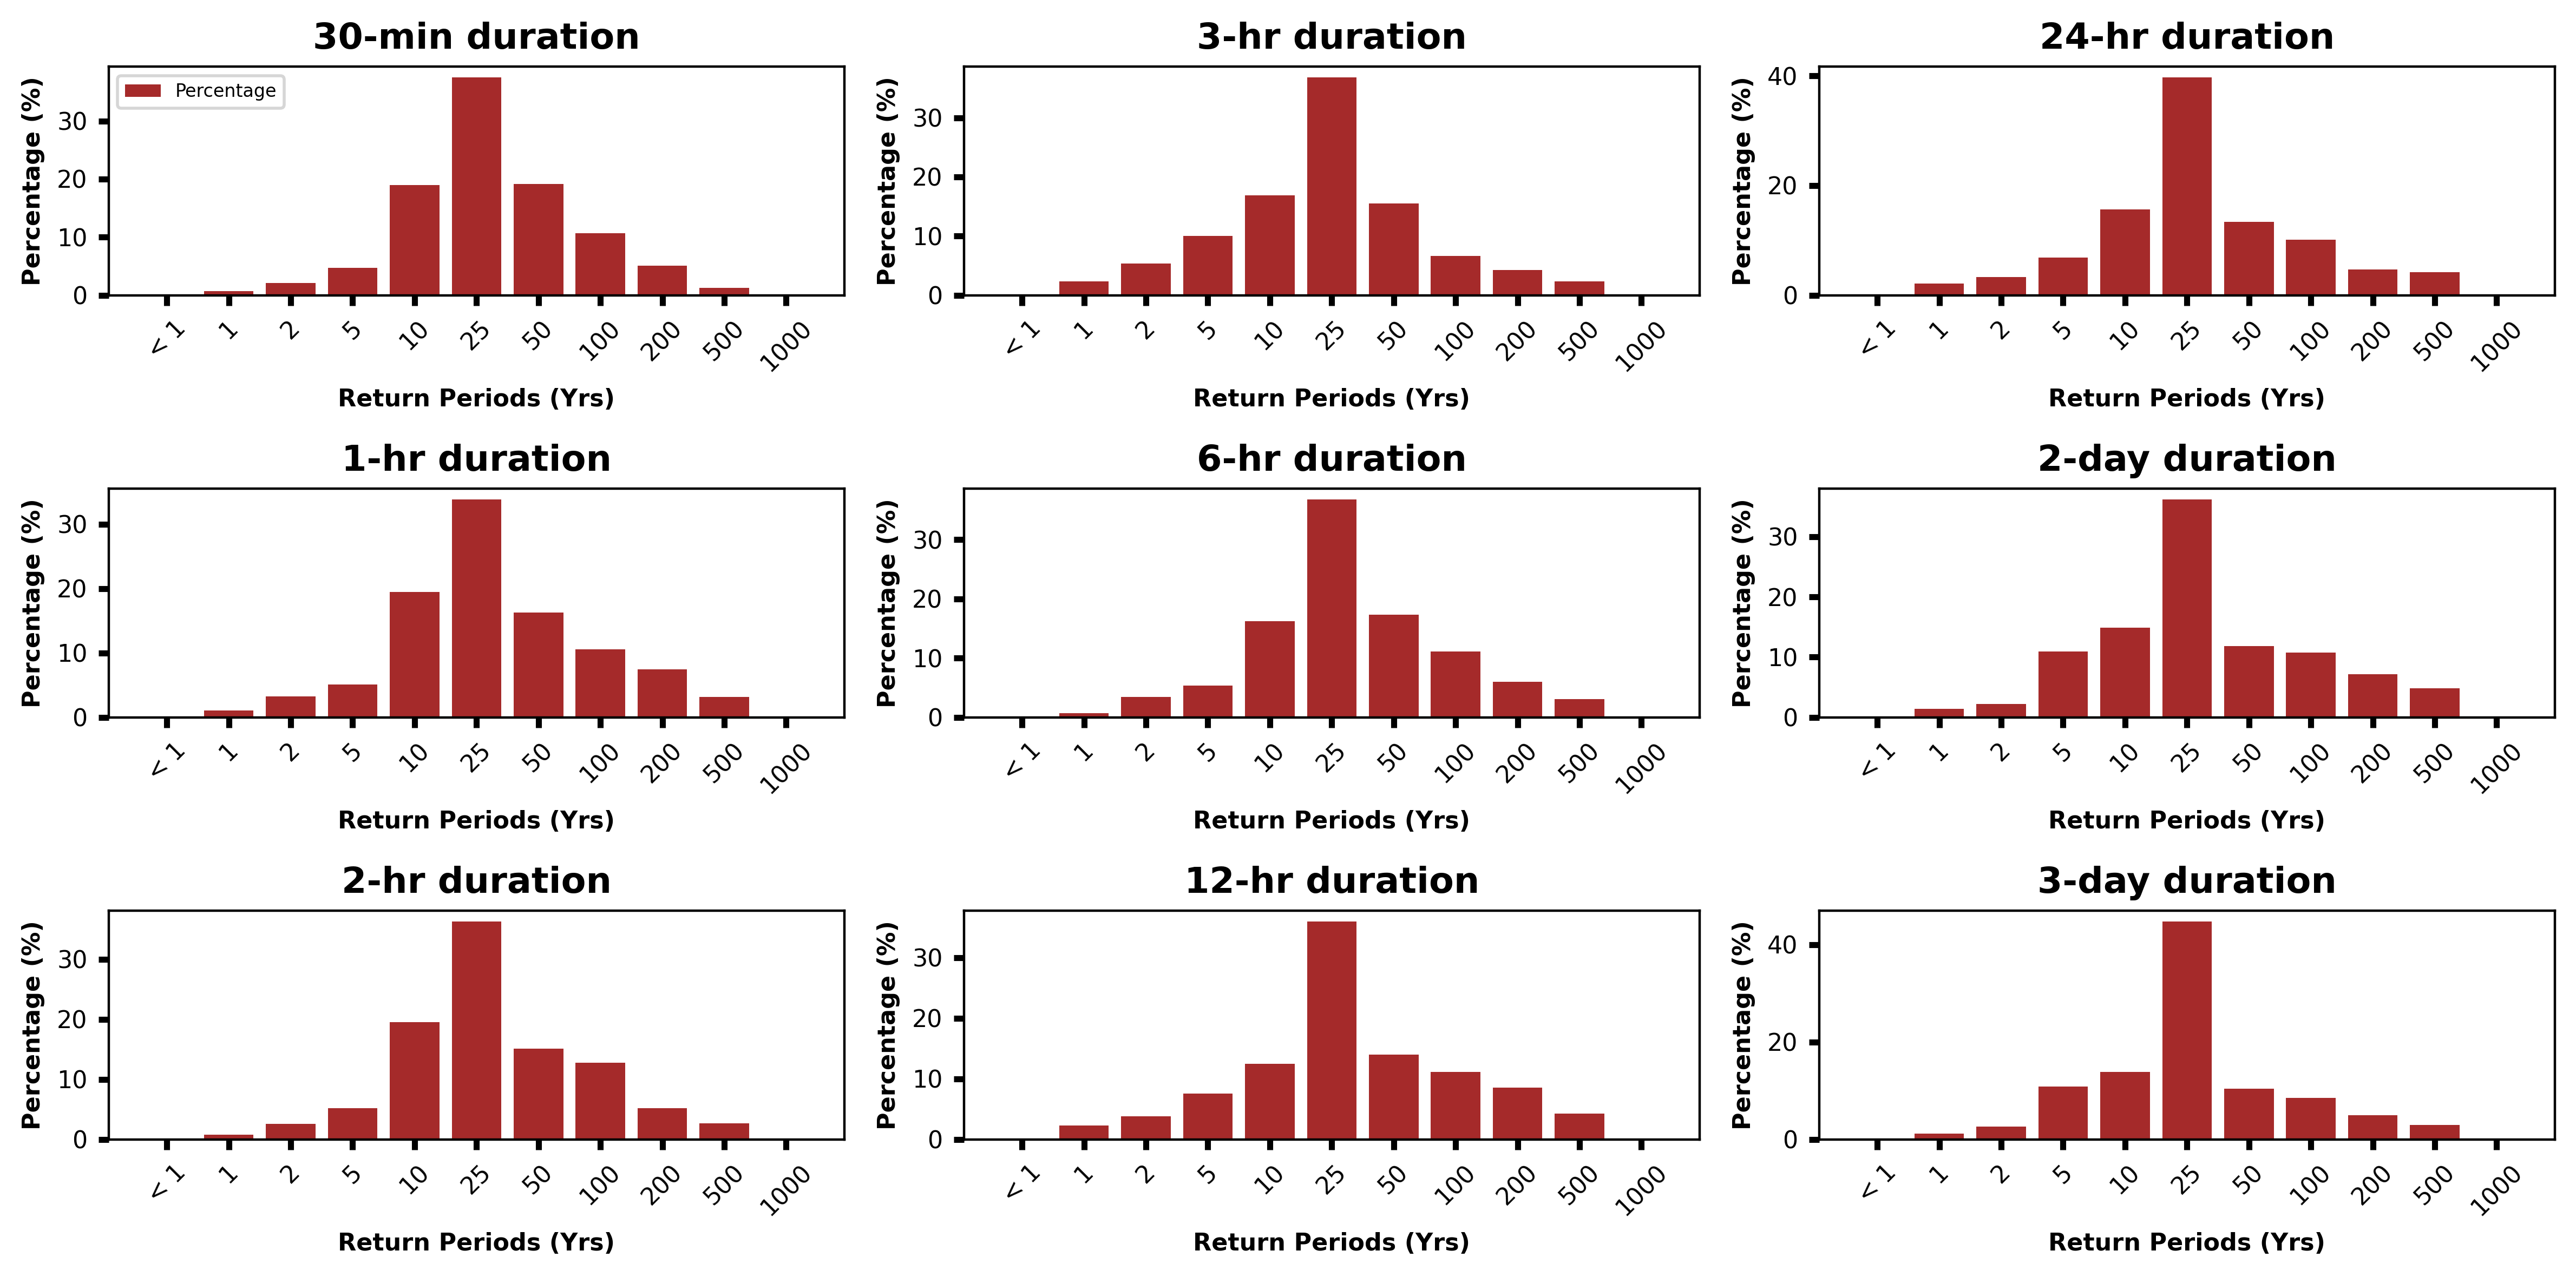

In [5]:
# Read in CSV
# dfa = pd.read_csv('./Final_imerg_atlas14_return_period.csv')         # imerg vs Atlas14
dfa = pd.read_csv('./Final_noaa_atlas14_return_period.csv')        # noaa vs Atlas14 
# dfa = pd.read_csv('./Final_hershfield_atlas14_return_period.csv')  # hershfield vs Atlas14
# dfa = pd.read_csv('./Imerg_noaa_return_period.csv')          
# print(dfa)

labels = ['< 1', '1', '2', '5', '10', '25', '50', '100','200', '500','1000']


## Pass dataset to array
xar1 = dfa.to_xarray()


SN = xar1['SN'];
RP = xar1['RP'];
F30m = xar1['30mF']; P30m = xar1['30mP'];
F1h = xar1['1hF'];   P1h = xar1['1hP'];
F2h = xar1['2hF'];   P2h = xar1['2hP'];
F3h = xar1['3hF'];   P3h = xar1['3hP'];
F6h = xar1['6hF'];   P6h = xar1['6hP'];
F12h = xar1['12hF']; P12h = xar1['12hP'];
F24h = xar1['24hF']; P24h = xar1['24hP'];
F2D = xar1['2DF'];   P2D = xar1['2DP'];
F3D = xar1['3DF'];   P3D = xar1['3DP'];

plt.figure(figsize=(12, 6), dpi=400)
collor = 'brown'; # indigo, blue, darkblue, brown, red, violet, darkviolet

# 30-min Assessment
plt.subplot(3,3,1) #projection='3d'
# plt.bar(SN, F30m, color=collor, label = "Frequency")
plt.bar(SN, P30m, color=collor, label = "Percentage")  #Percentage
plt.xlabel('Return Periods (Yrs)', fontweight='bold', fontsize=8)
plt.ylabel('Percentage (%)', fontweight='bold', fontsize=8) # Percentage (%)
# plt.ylabel('Frequency', fontweight='bold', fontsize=8) # Frequency
plt.title('30-min duration', fontweight='bold', fontsize=12)
plt.legend(loc=2, fontsize=6)
plt.xticks(SN, labels,  rotation=45, fontsize=6) 
plt.tick_params(axis='both', which='major', labelsize=8, width=2)

# 1-hr Assessment
plt.subplot(3,3,4) #projection='3d'
# plt.bar(SN, F1h, color=collor, label = "Frequency")
plt.bar(SN, P1h, color=collor, label = "Percentage")
plt.xlabel('Return Periods (Yrs)', fontweight='bold', fontsize=8)
plt.ylabel('Percentage (%)', fontweight='bold', fontsize=8) # Percentage (%)
# plt.ylabel('Frequency', fontweight='bold', fontsize=8) # Frequency
plt.title('1-hr duration', fontweight='bold', fontsize=12)
plt.xticks(SN, labels,  rotation=45, fontsize=6) 
plt.tick_params(axis='both', which='major', labelsize=8, width=2)

# 2-hr Assessment
plt.subplot(3,3,7) #projection='3d'
# plt.bar(SN, F2h, color=collor, label = "Frequency")
plt.bar(SN, P2h, color=collor, label = "Percentage")
plt.xlabel('Return Periods (Yrs)', fontweight='bold', fontsize=8)
plt.ylabel('Percentage (%)', fontweight='bold', fontsize=8) # Percentage (%)
# plt.ylabel('Frequency', fontweight='bold', fontsize=8) # Frequency
plt.title('2-hr duration', fontweight='bold', fontsize=12)
plt.xticks(SN, labels,  rotation=45, fontsize=6) 
plt.tick_params(axis='both', which='major', labelsize=8, width=2)

# 3-hr Assessment
plt.subplot(3,3,2) #projection='3d'
# plt.bar(SN, F3h, color=collor, label = "Frequency")
plt.bar(SN, P3h, color=collor, label = "Percentage")
plt.xlabel('Return Periods (Yrs)', fontweight='bold', fontsize=8)
plt.ylabel('Percentage (%)', fontweight='bold', fontsize=8) # Percentage (%)
# plt.ylabel('Frequency', fontweight='bold', fontsize=8) # Frequency
plt.title('3-hr duration', fontweight='bold', fontsize=12)
plt.xticks(SN, labels,  rotation=45, fontsize=6) 
plt.tick_params(axis='both', which='major', labelsize=8, width=2)

# 6-hr Assessment
plt.subplot(3,3,5) #projection='3d'
# plt.bar(SN, F6h, color=collor, label = "Frequency")
plt.bar(SN, P6h, color=collor, label = "Percentage")
plt.xlabel('Return Periods (Yrs)', fontweight='bold', fontsize=8)
plt.ylabel('Percentage (%)', fontweight='bold', fontsize=8) # Percentage (%)
# plt.ylabel('Frequency', fontweight='bold', fontsize=8) # Frequency
plt.title('6-hr duration', fontweight='bold', fontsize=12)
plt.xticks(SN, labels,  rotation=45, fontsize=6) 
plt.tick_params(axis='both', which='major', labelsize=8, width=2)

# 12-hr Assessment
plt.subplot(3,3,8) #projection='3d'
# plt.bar(SN, F12h, color=collor, label = "Frequency")
plt.bar(SN, P12h, color=collor, label = "Percentage")
plt.xlabel('Return Periods (Yrs)', fontweight='bold', fontsize=8)
plt.ylabel('Percentage (%)', fontweight='bold', fontsize=8) # Percentage (%)
# plt.ylabel('Frequency', fontweight='bold', fontsize=8) # Frequency
plt.title('12-hr duration', fontweight='bold', fontsize=12)
plt.xticks(SN, labels,  rotation=45, fontsize=6) 
plt.tick_params(axis='both', which='major', labelsize=8, width=2)

# 24-hr Assessment
plt.subplot(3,3,3) #projection='3d'
# plt.bar(SN, F24h, color=collor, label = "Frequency")
plt.bar(SN, P24h, color=collor, label = "Percentage")
plt.xlabel('Return Periods (Yrs)', fontweight='bold', fontsize=8)
plt.ylabel('Percentage (%)', fontweight='bold', fontsize=8) # Percentage (%)
# plt.ylabel('Frequency', fontweight='bold', fontsize=8) # Frequency
plt.title('24-hr duration', fontweight='bold', fontsize=12)
plt.xticks(SN, labels,  rotation=45, fontsize=6) 
plt.tick_params(axis='both', which='major', labelsize=8, width=2)

# 2-day Assessment
plt.subplot(3,3,6) #projection='3d'
# plt.bar(SN, F2D, color=collor, label = "Frequency")
plt.bar(SN, P2D, color=collor, label = "Percentage")
plt.xlabel('Return Periods (Yrs)', fontweight='bold', fontsize=8)
plt.ylabel('Percentage (%)', fontweight='bold', fontsize=8) # Percentage (%)
# plt.ylabel('Frequency', fontweight='bold', fontsize=8) # Frequency
plt.title('2-day duration', fontweight='bold', fontsize=12)
plt.xticks(SN, labels,  rotation=45, fontsize=6) 
plt.tick_params(axis='both', which='major', labelsize=8, width=2)

# 3-day Assessment
plt.subplot(3,3,9) #projection='3d'
# plt.bar(SN, F3D, color=collor, label = "Frequency")
plt.bar(SN, P3D, color=collor, label = "Percentage")
plt.xlabel('Return Periods (Yrs)', fontweight='bold', fontsize=8)
plt.ylabel('Percentage (%)', fontweight='bold', fontsize=8) # Percentage (%)
# plt.ylabel('Frequency', fontweight='bold', fontsize=8) # Frequency
plt.title('3-day duration', fontweight='bold', fontsize=12)
plt.xticks(SN, labels,  rotation=45, fontsize=6)  # weight = 'bold'
plt.tick_params(axis='both', which='major', labelsize=8, width=2)

plt.subplots_adjust(hspace=0.9, wspace=0.35)

plt.tight_layout()
# plt.savefig("Plots/ReturnPercentageHershfield.png")
plt.show()